若將圖片Resize成 (224, 224)，會造成Kaggle CPU不足，因此忍痛將Resize移除。

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms
from torch.utils import data

if torch.cuda.is_available():  
    torch.cuda.empty_cache()
    dev = "cuda:0" 
else:  
    dev = "cpu"

class ResNet(nn.Module):
    def __init__(self, num_classes=10, pretrained = True, freeze = False):
        super(ResNet, self).__init__()
        if pretrained:
            self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        else:
            self.model = models.resnet18(weights = None)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
            for param in self.model.fc.parameters():
                param.requires_grad = True


    def forward(self, x):
        return self.model(x)

class CIFAR10(data.Dataset):
    def __init__(self, x, y, transform = True):
        self.x = x
        self.y = y
        if transform:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                #transforms.Resize((224, 224), antialias=True),
                transforms.RandomHorizontalFlip(p = 0.5),
                transforms.RandomVerticalFlip(p = 0.5),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                #transforms.Resize((224, 224), antialias=True),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
            ])
            
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        img = self.x[index]
        img = self.transform(img)
        label = torch.from_numpy(self.y[index]).float()
        return img, label
        

In [2]:
import csv

def SaveCsvForPlot(filename, train_result, test_result):
    data = [(train_acc, test_acc) for train_acc, test_acc in zip(train_result, test_result)]
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)

def train(model, train_set, test_set, batch_size, epochs, lr, csv_name = "report"):
    train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_set, batch_size = batch_size)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_accuracy_plot = []
    test_accuracy_plot = []

    for epoch in range(epochs):
        model.train()
        train_loss=0
        train_accuracy=0.0
        for x, y in tqdm(train_loader):
            x, y = x.to(dev).float(), y.to(dev).to(torch.int64)
            optimizer.zero_grad()
            output=model(x).float()
            y = y.squeeze()
            loss=loss_function(output,y)
            loss.backward()
            train_loss+=loss
            optimizer.step()
            _,preds = torch.max(output.data,1)
            train_accuracy+=int(torch.sum(preds==y.data))
            
        model.eval()
        test_loss=0
        test_accuracy=0.0
        with torch.no_grad():
            for x, y in tqdm(test_loader):
                x, y = x.to(dev).float(), y.to(dev).to(torch.int64)
                output=model(x).float()
                y = y.squeeze()
                loss=loss_function(output,y)
                test_loss+=loss
                _,preds = torch.max(output.data,1)
                test_accuracy+=int(torch.sum(preds==y.data))

        print(f"Epoch {epoch+1}: train accuracy = {train_accuracy/len(train_set)}, test accuracy = {test_accuracy/len(test_set)}")    
        train_accuracy_plot.append(train_accuracy/len(train_set))
        test_accuracy_plot.append(test_accuracy/len(test_set)) 
        SaveCsvForPlot(f'{csv_name}.csv',train_accuracy_plot, test_accuracy_plot)

In [3]:
train_x, train_y, test_x, test_y =np.load('/kaggle/input/cifar-10/x_train.npy'), np.load('/kaggle/input/cifar-10/y_train.npy'), np.load('/kaggle/input/cifar-10/x_test.npy'), np.load('/kaggle/input/cifar-10/y_test.npy')


In [4]:
train_set = CIFAR10(train_x, train_y)
test_set = CIFAR10(test_x, test_y, False)

model = ResNet().to(dev)
batch_size = 4
epochs = 20
lr = 1e-4
csv_name = "Pretrained_ResNet18"

train(model, train_set, test_set, batch_size, epochs, lr, csv_name)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]
100%|██████████| 2500/2500 [00:09<00:00, 261.51it/s]


Epoch 1: train accuracy = 0.3935, test accuracy = 0.5654


100%|██████████| 2500/2500 [00:09<00:00, 252.32it/s]


Epoch 2: train accuracy = 0.5113, test accuracy = 0.5798


100%|██████████| 2500/2500 [00:09<00:00, 261.88it/s]


Epoch 3: train accuracy = 0.5846, test accuracy = 0.6616


100%|██████████| 2500/2500 [00:09<00:00, 257.53it/s]


Epoch 4: train accuracy = 0.62142, test accuracy = 0.6547


100%|██████████| 2500/2500 [00:09<00:00, 261.71it/s]


Epoch 5: train accuracy = 0.6525, test accuracy = 0.683


100%|██████████| 2500/2500 [00:09<00:00, 257.44it/s]


Epoch 6: train accuracy = 0.6742, test accuracy = 0.6802


100%|██████████| 2500/2500 [00:09<00:00, 253.01it/s]


Epoch 7: train accuracy = 0.6959, test accuracy = 0.7322


100%|██████████| 2500/2500 [00:09<00:00, 267.28it/s]


Epoch 8: train accuracy = 0.70632, test accuracy = 0.7196


100%|██████████| 2500/2500 [00:09<00:00, 253.96it/s]


Epoch 9: train accuracy = 0.71888, test accuracy = 0.7228


100%|██████████| 2500/2500 [00:09<00:00, 264.45it/s]


Epoch 10: train accuracy = 0.73172, test accuracy = 0.7397


100%|██████████| 2500/2500 [00:09<00:00, 250.39it/s]


Epoch 11: train accuracy = 0.74066, test accuracy = 0.7466


100%|██████████| 2500/2500 [00:09<00:00, 263.67it/s]


Epoch 12: train accuracy = 0.75264, test accuracy = 0.7222


100%|██████████| 2500/2500 [00:09<00:00, 265.09it/s]


Epoch 13: train accuracy = 0.75624, test accuracy = 0.7272


100%|██████████| 2500/2500 [00:10<00:00, 248.43it/s]


Epoch 14: train accuracy = 0.76592, test accuracy = 0.7583


100%|██████████| 2500/2500 [00:09<00:00, 263.50it/s]


Epoch 15: train accuracy = 0.77282, test accuracy = 0.7322


100%|██████████| 2500/2500 [00:09<00:00, 264.06it/s]


Epoch 16: train accuracy = 0.78106, test accuracy = 0.7494


100%|██████████| 2500/2500 [00:10<00:00, 241.61it/s]


Epoch 17: train accuracy = 0.78668, test accuracy = 0.7604


100%|██████████| 2500/2500 [00:09<00:00, 256.01it/s]


Epoch 18: train accuracy = 0.79232, test accuracy = 0.7775


100%|██████████| 2500/2500 [00:09<00:00, 265.54it/s]


Epoch 19: train accuracy = 0.79808, test accuracy = 0.7738


100%|██████████| 2500/2500 [00:09<00:00, 253.36it/s]


Epoch 20: train accuracy = 0.80256, test accuracy = 0.7571


In [5]:
model = ResNet(pretrained = False).to(dev)
csv_name = "ResNet18"

train(model, train_set, test_set, batch_size, epochs, lr, csv_name)

100%|██████████| 2500/2500 [00:10<00:00, 236.71it/s]


Epoch 1: train accuracy = 0.29086, test accuracy = 0.439


100%|██████████| 2500/2500 [00:09<00:00, 261.76it/s]


Epoch 2: train accuracy = 0.42788, test accuracy = 0.5435


100%|██████████| 2500/2500 [00:09<00:00, 255.04it/s]


Epoch 3: train accuracy = 0.5122, test accuracy = 0.603


100%|██████████| 2500/2500 [00:09<00:00, 266.80it/s]


Epoch 4: train accuracy = 0.5567, test accuracy = 0.6001


100%|██████████| 2500/2500 [00:09<00:00, 257.65it/s]


Epoch 5: train accuracy = 0.5923, test accuracy = 0.6276


100%|██████████| 2500/2500 [00:09<00:00, 263.74it/s]


Epoch 6: train accuracy = 0.61338, test accuracy = 0.6308


100%|██████████| 2500/2500 [00:10<00:00, 241.90it/s]


Epoch 7: train accuracy = 0.63998, test accuracy = 0.6672


100%|██████████| 2500/2500 [00:11<00:00, 214.60it/s]


Epoch 8: train accuracy = 0.6563, test accuracy = 0.677


100%|██████████| 2500/2500 [00:10<00:00, 230.18it/s]


Epoch 9: train accuracy = 0.673, test accuracy = 0.6793


100%|██████████| 2500/2500 [00:11<00:00, 225.52it/s]


Epoch 10: train accuracy = 0.68392, test accuracy = 0.6926


100%|██████████| 2500/2500 [00:11<00:00, 217.82it/s]


Epoch 11: train accuracy = 0.69626, test accuracy = 0.6987


100%|██████████| 2500/2500 [00:10<00:00, 233.74it/s]


Epoch 12: train accuracy = 0.70662, test accuracy = 0.7014


100%|██████████| 2500/2500 [00:10<00:00, 241.03it/s]


Epoch 13: train accuracy = 0.71602, test accuracy = 0.7142


100%|██████████| 2500/2500 [00:09<00:00, 266.32it/s]


Epoch 14: train accuracy = 0.72404, test accuracy = 0.7175


100%|██████████| 2500/2500 [00:09<00:00, 265.90it/s]


Epoch 15: train accuracy = 0.73454, test accuracy = 0.7158


100%|██████████| 2500/2500 [00:09<00:00, 254.21it/s]


Epoch 16: train accuracy = 0.74262, test accuracy = 0.715


100%|██████████| 2500/2500 [00:09<00:00, 266.85it/s]


Epoch 17: train accuracy = 0.74728, test accuracy = 0.7164


100%|██████████| 2500/2500 [00:09<00:00, 262.51it/s]


Epoch 18: train accuracy = 0.75476, test accuracy = 0.7302


100%|██████████| 2500/2500 [00:09<00:00, 268.80it/s]


Epoch 19: train accuracy = 0.76078, test accuracy = 0.7407


100%|██████████| 2500/2500 [00:10<00:00, 239.41it/s]


Epoch 20: train accuracy = 0.76794, test accuracy = 0.7406


In [6]:
model = ResNet(freeze = True).to(dev)
csv_name = "Freezed_ResNet18"

train(model, train_set, test_set, batch_size, epochs, lr, csv_name)

100%|██████████| 2500/2500 [00:10<00:00, 242.57it/s]


Epoch 1: train accuracy = 0.26766, test accuracy = 0.2943


100%|██████████| 2500/2500 [00:09<00:00, 265.32it/s]


Epoch 2: train accuracy = 0.31798, test accuracy = 0.3246


100%|██████████| 2500/2500 [00:09<00:00, 270.23it/s]


Epoch 3: train accuracy = 0.32672, test accuracy = 0.3319


100%|██████████| 2500/2500 [00:09<00:00, 265.82it/s]


Epoch 4: train accuracy = 0.32802, test accuracy = 0.3468


100%|██████████| 2500/2500 [00:09<00:00, 268.74it/s]


Epoch 5: train accuracy = 0.3314, test accuracy = 0.3276


100%|██████████| 2500/2500 [00:09<00:00, 257.13it/s]


Epoch 6: train accuracy = 0.33302, test accuracy = 0.3335


100%|██████████| 2500/2500 [00:09<00:00, 268.59it/s]


Epoch 7: train accuracy = 0.3305, test accuracy = 0.3379


100%|██████████| 2500/2500 [00:09<00:00, 267.26it/s]


Epoch 8: train accuracy = 0.3263, test accuracy = 0.3549


100%|██████████| 2500/2500 [00:11<00:00, 215.04it/s]


Epoch 9: train accuracy = 0.3309, test accuracy = 0.339


100%|██████████| 2500/2500 [00:09<00:00, 257.59it/s]


Epoch 10: train accuracy = 0.33248, test accuracy = 0.3353


100%|██████████| 2500/2500 [00:09<00:00, 257.71it/s]


Epoch 11: train accuracy = 0.33236, test accuracy = 0.3354


100%|██████████| 2500/2500 [00:09<00:00, 265.51it/s]


Epoch 12: train accuracy = 0.33322, test accuracy = 0.3505


100%|██████████| 2500/2500 [00:09<00:00, 265.88it/s]


Epoch 13: train accuracy = 0.3364, test accuracy = 0.3357


100%|██████████| 2500/2500 [00:09<00:00, 267.80it/s]


Epoch 14: train accuracy = 0.33378, test accuracy = 0.3389


100%|██████████| 2500/2500 [00:09<00:00, 266.96it/s]


Epoch 15: train accuracy = 0.33628, test accuracy = 0.3348


100%|██████████| 2500/2500 [00:09<00:00, 258.68it/s]


Epoch 16: train accuracy = 0.33556, test accuracy = 0.351


100%|██████████| 2500/2500 [00:09<00:00, 268.65it/s]


Epoch 17: train accuracy = 0.33374, test accuracy = 0.3576


100%|██████████| 2500/2500 [00:11<00:00, 209.09it/s]


Epoch 18: train accuracy = 0.3318, test accuracy = 0.3603


100%|██████████| 2500/2500 [00:11<00:00, 221.68it/s]


Epoch 19: train accuracy = 0.33498, test accuracy = 0.3451


100%|██████████| 2500/2500 [00:09<00:00, 268.35it/s]

Epoch 20: train accuracy = 0.33156, test accuracy = 0.3649


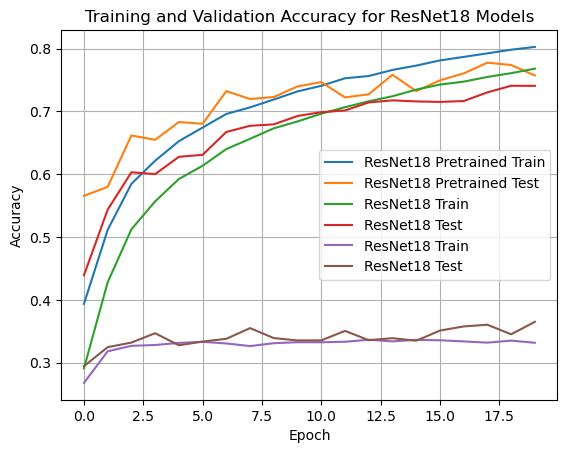

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

Pretrained = pd.read_csv('/kaggle/working/Pretrained_ResNet18.csv', header = None)
From_Scratch = pd.read_csv('/kaggle/working/ResNet18.csv', header = None)
Freezed = pd.read_csv("/kaggle/working/Freezed_ResNet18.csv", header = None)

train_column = 0  # Column index for train accuracy
valid_column = 1  # Column index for validation accuracy

# ResNet18
plt.plot(Pretrained[train_column], label='ResNet18 Pretrained Train')
plt.plot(Pretrained[valid_column], label='ResNet18 Pretrained Test')

# ResNet50
plt.plot(From_Scratch[train_column], label='ResNet18 Train')
plt.plot(From_Scratch[valid_column], label='ResNet18 Test')

# ResNet152
plt.plot(Freezed[train_column], label='ResNet18 Train')
plt.plot(Freezed[valid_column], label='ResNet18 Test')

plt.title('Training and Validation Accuracy for ResNet18 Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Result
Pretrained: 由於使用的是預訓練過的模型，在訓練初期就已有一定的表現

From Scatch: 在模型從零開始訓練的過程中，也得到了不錯的表現

Freeze Layer: 由於捲積層都被Freeze了，模型無法學習feature extraction的能力，因此表現不佳